In [33]:
# !pip install lightgbm

In [29]:
# ============================================
# 1) LOAD DATA
# ============================================
DELTA_GOLD = "../EDA/Deltas/Delta_gold2"
# df = df_fake.copy()





import pandas as pd
import numpy as np
from deltalake import DeltaTable

import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score


df = DeltaTable(DELTA_GOLD).to_pandas()

df["date"] = pd.date_range(start="2020-01-01", periods=len(df), freq="H")

df['date'] = pd.to_datetime(df['date'])



# ============================================
# 2) FEATURE SET
# ============================================
feature_columns = [
    "temperature_max",
    "wind_speed_max",
    "precipitation_total",
    "relative_humidity",
    "soil_moisture",
    "evapotranspiration",
    "shortwave_radiation",
    "day_of_year",
    "day_of_week",
    "is_weekend",
    "longitude",
    "latitude",
    "sea_distance"
]



label_col = "is_fire"
SPLIT_DATE = "2022-01-01"

# TIME-SPLIT
train_df = df[df["date"] < SPLIT_DATE].copy()
test_df = df[df["date"] >= SPLIT_DATE].copy()

# ============================================
# 3) CLEANING (Impute Missing Values)
# ============================================
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train = pd.DataFrame(imputer.fit_transform(train_df[feature_columns]), 
                       columns=feature_columns)
X_test = pd.DataFrame(imputer.transform(test_df[feature_columns]), 
                      columns=feature_columns)

y_train = train_df[label_col].astype(int)
y_test = test_df[label_col].astype(int)


# ============================================
# 5) LIGHTGBM TRAINING — FAST + EFFECTIVE
# ============================================
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import train_test_split

# ======================================================
# 1) TRAIN/VALID SPLIT
# ======================================================
# ============================================
# 4) TIME-BASED TRAIN/VALID SPLIT (CORRECT)
# ============================================
split_idx = int(len(train_df) * 0.8)

train_df2 = train_df.iloc[:split_idx]
valid_df = train_df.iloc[split_idx:]

X_train = train_df2[feature_columns]
y_train = train_df2[label_col].astype(int)

X_valid = valid_df[feature_columns]
y_valid = valid_df[label_col].astype(int)





# ======================================================
# 2) LIGHTGBM DATASETS
# ======================================================
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

# ======================================================
# 3) LIGHTGBM PARAMS
# ======================================================
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 64,
    "max_depth": -1,
    "min_data_in_leaf": 40,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 1.0,
    "lambda_l2": 1.0,
    "scale_pos_weight": 1,
    "seed": 42,
}

# ======================================================
# 4) TRAIN (COMPATIBLE WITH ALL VERSIONS)
# ======================================================
print("Training LightGBM...")

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=400,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=40),
        log_evaluation(50)
    ]
)

print("Training complete.")
print("Best iteration:", lgb_model.best_iteration)

# ======================================================
# 5) PREDICTIONS
# ======================================================
y_scores = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)


thresholds = np.arange(0.1, 0.9, 0.02)

best_f1 = 0
best_t = 0.5

y_prob = lgb_model.predict(X_test)


for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("\nBest threshold:", best_t)
print("Best F1 at that threshold:", best_f1)




y_pred = (y_prob >= best_t).astype(int)





Training LightGBM...
[LightGBM] [Info] Number of positive: 4722, number of negative: 9313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336445 -> initscore=-0.679179
[LightGBM] [Info] Start training from score -0.679179
Training until validation scores don't improve for 40 rounds
[50]	train's auc: 0.931706	valid's auc: 0.906849
[100]	train's auc: 0.942342	valid's auc: 0.907797
Early stopping, best iteration is:
[107]	train's auc: 0.943773	valid's auc: 0.907893
Training complete.
Best iteration: 107

Best threshold: 0.3600000000000001
Best F1 at that threshold: 0.769428018211314



=== LIGHTGBM METRICS ===
Accuracy: 0.8279846958694463
Precision: 0.7108564798027414
Recall: 0.8385183495394793
F1: 0.769428018211314
ROC AUC: 0.9104295256623213
PR AUC: 0.835445596579391

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     67387
           1       0.71      0.84      0.77     35069

    accuracy                           0.83    102456
   macro avg       0.81      0.83      0.82    102456
weighted avg       0.84      0.83      0.83    102456



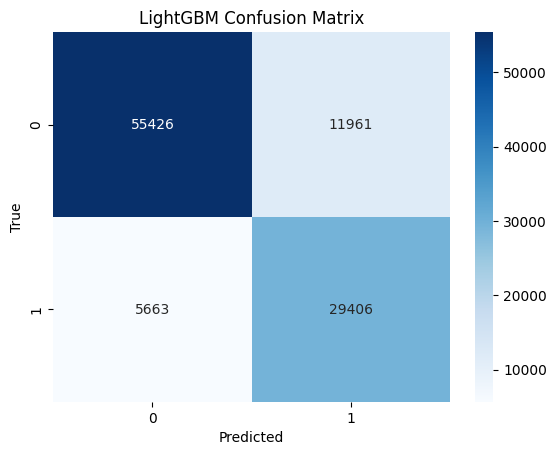


=== FEATURE IMPORTANCE ===
                Feature  Importance
1        wind_speed_max         912
7           day_of_year         858
3     relative_humidity         679
6   shortwave_radiation         668
0       temperature_max         620
4         soil_moisture         608
2   precipitation_total         567
5    evapotranspiration         464
11             latitude         459
10            longitude         424
12         sea_distance         387
8           day_of_week          92
9            is_weekend           3


In [30]:
# ============================================
# 7) EVALUATION
# ============================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix
)

print("\n=== LIGHTGBM METRICS ===")


print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC:", average_precision_score(y_test, y_prob))


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ============================================
# 8) CONFUSION MATRIX
# ============================================
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================
# 9) FEATURE IMPORTANCE
# ============================================
importances = lgb_model.feature_importance()
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(fi_df)

In [32]:
import lightgbm as lgb
import joblib
import sklearn

print("LightGBM:", lgb.__version__)
print("joblib:", joblib.__version__)
print("sklearn:", sklearn.__version__)


LightGBM: 4.6.0
joblib: 1.5.2
sklearn: 1.7.2


In [31]:

# Extract raw booster
booster = model.booster_

# Save as .txt (portable format)
booster.save_model("lightgbm_fire_model.txt")


In [27]:
from lightgbm import LGBMClassifier
import joblib

model = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31
)

model.fit(X_train, y_train)

joblib.dump(model, "model/lightgbm_fire_model.pkl")


[LightGBM] [Info] Number of positive: 4722, number of negative: 9313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 14035, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336445 -> initscore=-0.679179
[LightGBM] [Info] Start training from score -0.679179


['lightgbm_fire_model1.pkl']

In [13]:
import pandas as pd

def test_sample(sample):
    df = pd.DataFrame([sample])
    prediction = lgb_model.predict(df)[0]
    print("🔥 Predicted fire risk:", prediction)
    return prediction



In [21]:
# sample = {
#     "temperature_max": 18,
#     "wind_speed_max": 12,
#     "precipitation_total": 5,
#     "relative_humidity": 80,
#     "soil_moisture": 0.40,
#     "evapotranspiration": 1.0,
#     "shortwave_radiation": 120,
#     "day_of_year": 40,
#     "day_of_week": 3,
#     "is_weekend": 0,
#     "longitude": -6.8,
#     "latitude": 34.0,
#     "sea_distance": 10
# } # result is  0.02419922782251652

# sample = {
#     "temperature_max": 42,
#     "wind_speed_max": 70,
#     "precipitation_total": 0,
#     "relative_humidity": 20,
#     "soil_moisture": 0.05,
#     "evapotranspiration": 5.5,
#     "shortwave_radiation": 380,
#     "day_of_year": 210,
#     "day_of_week": 5,
#     "is_weekend": 1,
#     "longitude": -7.3,
#     "latitude": 30.5,
#     "sea_distance": 180
# } # result is 0.9009632185366085

# sample = {
#     "temperature_max": 29,
#     "wind_speed_max": 32,
#     "precipitation_total": 0.8,
#     "relative_humidity": 45,
#     "soil_moisture": 0.18,
#     "evapotranspiration": 2.7,
#     "shortwave_radiation": 260,
#     "day_of_year": 165,
#     "day_of_week": 2,
#     "is_weekend": 0,
#     "longitude": -5.2,
#     "latitude": 33.5,
#     "sea_distance": 95
# } # result is 0.27177313946208065

sample = {
    "temperature_max": 40,
    "wind_speed_max": 45,
    "precipitation_total": 0,
    "relative_humidity": 25,
    "soil_moisture": 0.10,
    "evapotranspiration": 4.2,
    "shortwave_radiation": 310,
    "day_of_year": 190,
    "day_of_week": 6,
    "is_weekend": 1,
    "longitude": -8.0,
    "latitude": 31.6,
    "sea_distance": 160
} # result is 0.866776338047372

test_sample(sample)

🔥 Predicted fire risk: 0.866776338047372


0.866776338047372

In [22]:
results = X_test.copy()
results['date'] = df.loc[X_test.index, 'date']
results['True Label'] = y_test
results['Predicted Probability'] = y_prob
results['Predicted Label'] = y_pred

print("\n--- Sample Predictions ---")
results.head(10)


--- Sample Predictions ---


,temperature_max,wind_speed_max,precipitation_total,relative_humidity,soil_moisture,evapotranspiration,shortwave_radiation,day_of_year,day_of_week,is_weekend,longitude,latitude,sea_distance,date,True Label,Predicted Probability,Predicted Label
0,20.560677,41.803054,2.079524,77.565152,0.077843,1.922368,275.831242,203.0,2.0,0.0,-10.310707,28.598491,169.616547,2020-01-01 00:00:00,NaN,0.182347,0
1,26.960932,39.001292,0.327759,62.897575,0.000000,3.939121,339.691436,248.0,6.0,1.0,-7.107023,22.080310,300.000000,2020-01-01 01:00:00,NaN,0.714209,1
2,23.371128,40.895770,4.607677,79.021758,0.022772,3.004538,192.753128,181.0,0.0,0.0,-1.036553,30.777004,300.000000,2020-01-01 02:00:00,NaN,0.194580,0
3,29.384927,37.898319,2.449696,66.023445,0.047816,2.877480,345.705098,275.0,1.0,0.0,-2.429513,33.680091,216.205495,2020-01-01 03:00:00,NaN,0.380222,1
4,22.960406,48.642171,5.814850,75.718648,0.068593,2.091223,221.888678,30.0,2.0,0.0,-1.112007,34.477721,266.807591,2020-01-01 04:00:00,NaN,0.102272,0
5,29.085824,39.974313,4.147674,62.330514,0.024350,3.722464,256.813029,247.0,6.0,1.0,-11.481251,24.394918,300.000000,2020-01-01 05:00:00,NaN,0.707061,1
6,20.377308,34.286695,15.787509,70.995817,0.190865,2.285024,168.254266,25.0,1.0,0.0,-7.629185,30.831320,194.595999,2020-01-01 06:00:00,NaN,0.036941,0
7,17.973173,55.607347,4.558012,89.916628,0.040344,2.571180,139.537438,66.0,4.0,0.0,-6.367223,21.185082,300.000000,2020-01-01 07:00:00,NaN,0.090936,0
8,20.962120,39.891293,3.796508,82.400162,0.049879,1.694821,237.414551,185.0,2.0,0.0,-6.532772,30.657847,295.166241,2020-01-01 08:00:00,NaN,0.105454,0
9,18.368709,46.027037,1.241967,80.628465,0.017923,1.679321,159.428266,164.0,5.0,1.0,-8.025319,32.530340,125.370104,2020-01-01 09:00:00,NaN,0.074344,0



GENERATING 6-PANEL LIGHTGBM EVALUATION MAP


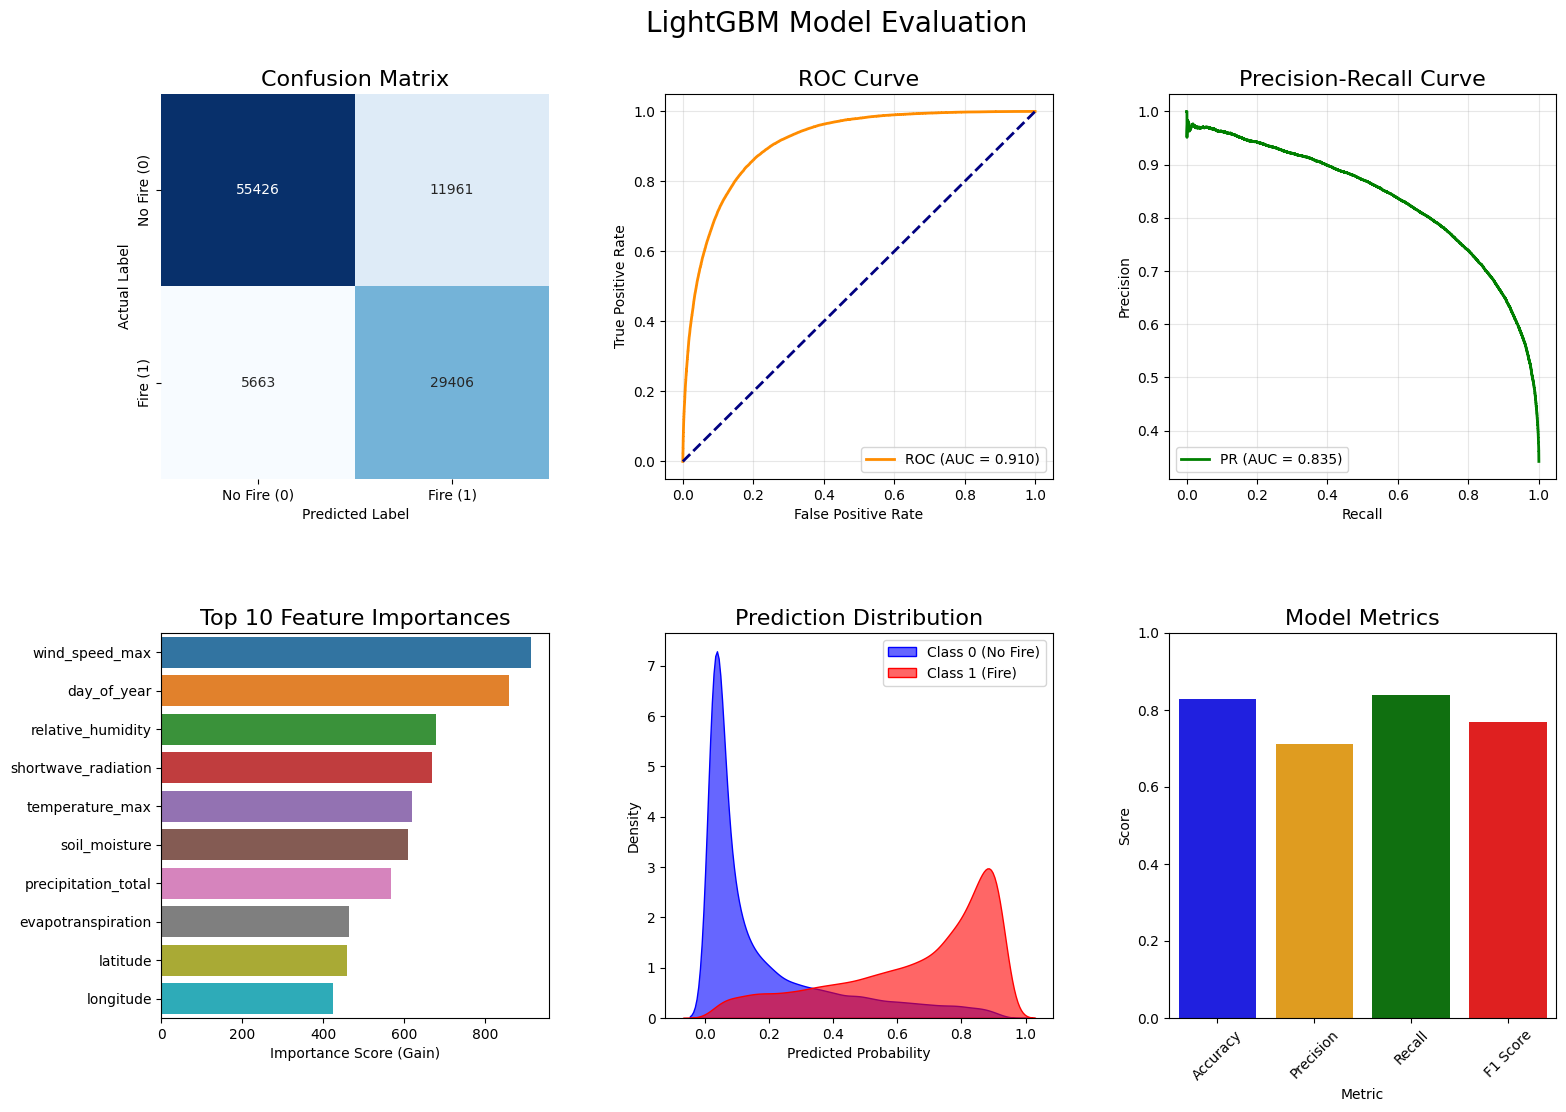

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

# --- Define Necessary Variables (Assuming LightGBM training was successful) ---
# These variables should be defined in your environment from the previous steps:
# y_test, y_pred, y_prob, X_train_fe, lgb_model

y_test_final = y_test
y_pred_final = y_pred
y_prob_final = y_prob
feature_names = X_train.columns
importances = lgb_model.feature_importance()

# Define the dictionary of key metrics for the Model Metrics bar chart
metrics_dict = {
    'Accuracy': accuracy_score(y_test_final, y_pred_final),
    'Precision': precision_score(y_test_final, y_pred_final),
    'Recall': recall_score(y_test_final, y_pred_final),
    'F1 Score': f1_score(y_test_final, y_pred_final),
    'ROC AUC': roc_auc_score(y_test_final, y_prob_final),
    'PR AUC': average_precision_score(y_test_final, y_prob_final),
}

# --- Create the 6-Panel Visualization Map ---
print("\n" + "="*50)
print("GENERATING 6-PANEL LIGHTGBM EVALUATION MAP")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Expanded size for clarity
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('LightGBM Model Evaluation', fontsize=20, y=0.95)

# -----------------
# 1. Confusion Matrix (Top-Left)
# -----------------
cm = confusion_matrix(y_test_final, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            cbar=False,
            xticklabels=["No Fire (0)", "Fire (1)"],
            yticklabels=["No Fire (0)", "Fire (1)"])
axes[0, 0].set_title('Confusion Matrix', fontsize=16)
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_ylabel('Actual Label')
# 
# -----------------
# 2. ROC Curve (Top-Center)
# -----------------
fpr, tpr, _ = roc_curve(y_test_final, y_prob_final)
roc_auc = metrics_dict['ROC AUC']
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontsize=16)
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(True, alpha=0.3)
# 
# -----------------
# 3. Precision-Recall Curve (Top-Right)
# -----------------
precision, recall, _ = precision_recall_curve(y_test_final, y_prob_final)
pr_auc = metrics_dict['PR AUC']
axes[0, 2].plot(recall, precision, color='green', lw=2, 
                label=f'PR (AUC = {pr_auc:.3f})')
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve', fontsize=16)
axes[0, 2].legend(loc="lower left")
axes[0, 2].grid(True, alpha=0.3)
# 
# -----------------
# 4. Top 10 Feature Importances (Bottom-Left)
# -----------------
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False).head(10)

sns.barplot(x="Importance", y="Feature", data=fi_df, ax=axes[1, 0], palette="tab10")
axes[1, 0].set_title('Top 10 Feature Importances', fontsize=16)
axes[1, 0].set_xlabel('Importance Score (Gain)')
axes[1, 0].set_ylabel('')
# 
# -----------------
# 5. Prediction Distribution (Bottom-Center)
# -----------------
# Using Kernel Density Estimation (KDE) for cleaner visualization than histogram
sns.kdeplot(y_prob_final[y_test_final == 0], label='Class 0 (No Fire)', 
            color='blue', ax=axes[1, 1], fill=True, alpha=0.6)
sns.kdeplot(y_prob_final[y_test_final == 1], label='Class 1 (Fire)', 
            color='red', ax=axes[1, 1], fill=True, alpha=0.6)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Prediction Distribution', fontsize=16)
axes[1, 1].legend()
# 
# -----------------
# 6. Model Metrics (Bottom-Right)
# -----------------
metrics_df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Value'])
sns.barplot(x='Metric', y='Value', data=metrics_df.drop(index=[4, 5]), # Exclude AUCs for cleaner scale
            ax=axes[1, 2], palette=['blue', 'orange', 'green', 'red'])
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Metrics', fontsize=16)
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].set_ylim(0, 1) # Metrics are scores between 0 and 1
# 
plt.show()